<a href="https://colab.research.google.com/github/Kasaligan/Machine-Learning-UNS/blob/main/TP6/Clase_6_Regresion_precios_de_casas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding Boston Housing Prices
The Boston housing dataset contains 506 observations and 14 variables. The goal of this project is to understand which of the variables in study drive the price of homes in Boston and to be able to predict prices from the atributes.  

In [798]:
import pandas as pd
true_news = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectBHP/data/housing_data.csv")
true_news.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,486.000000,486.000000,486.000000,486.000000,506.000000,506.000000,486.000000,506.000000,506.000000,506.000000,506.000000,506.000000,486.000000,506.000000
mean,3.611874,11.211934,11.083992,0.069959,0.554695,6.284634,68.518519,3.795043,9.549407,408.237154,18.455534,356.674032,12.715432,22.532806
std,8.720192,23.388876,6.835896,0.255340,0.115878,0.702617,27.999513,2.105710,8.707259,168.537116,2.164946,91.294864,7.155871,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.081900,0.000000,5.190000,0.000000,0.449000,5.885500,45.175000,2.100175,4.000000,279.000000,17.400000,375.377500,7.125000,17.025000
50%,0.253715,0.000000,9.690000,0.000000,0.538000,6.208500,76.800000,3.207450,5.000000,330.000000,19.050000,391.440000,11.430000,21.200000
75%,3.560262,12.500000,18.100000,0.000000,0.624000,6.623500,93.975000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


---
#***PLAN DE ACCION***

###IDEA

Para este trabajo mi idea es aplicar tres modelos. En primer lugar un regresor de tipo arbol, que si bien es mas pensado para regresion no parametrica tiene una confeccion intuitiva y puede ser usado tranquilamente para regresion numerica. La informacion del regresor de sklearn que usare esta en el siguiente link:

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor

Por otro lado quisiera probar regresion por vector soporte:

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR

Finalmente probar una regresion lineal multiple:

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

###Evaluación

Evaluare los resultados comparando los precios predichos con los reales y obteniendo el error porcentual maximo, minimo y promedio respecto al valor real. Graficare tambien la distribucion de los errores porcentuales. En base al analisis de estos resultados determinare cual modelo consiguio la mejor regresion.

Para determinar los parametros que mas influyen en el precio recuperare los coeficientes de la regresion lineal e identificare los mas grandes. Estos seran los que mayor influencia tienen en la regresion.


---
#***CODIGO***

##Pre-procesamiento de los datos

Importo librerias de interes

.

In [799]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

.

Importo mi funcion para graficar distribucion de los parametros

.

In [800]:
def plot_distributions(df,intervalos=0):  #la funcion grafica las distribuciones detro del dataset
  #el parametro df es el dataframe a analizar
  #intervalos son los intervalos para el histograma, por defecto recae en la raiz cuadrada del largo del dataframe
  rango=len(df.columns)#El numero de intervalos en el histograma
  if intervalos==0:
    intervalos=round(np.sqrt(len(df)))
  Tot = rango             #number_of_subplots
  Cols = rango//2         #number_of_columns
  # Compute Rows required
  Rows = Tot // Cols 
  Rows += Tot % Cols
  plt.figure()
  plt.figure(figsize=(30,15))
  print('GRAFICOS DE ', str)
  for i in range(rango):  
    v=i+1               #esto va aca pues i inicia en cero y el primer subplot es de indice 1
    plt.subplot(Rows,Cols,v)
    plt.hist(df.iloc[:,i], bins=intervalos, color='#F2AB6D', rwidth=0.85)
    plt.title(df.columns[i])

. 

Importo mi funcion de deteccion y correccion de outliers.

.

In [801]:
def outliers_correction(df):
  from sklearn.neighbors import LocalOutlierFactor
  n_neighbors=int(np.round(np.sqrt(len(df))))
  lof=LocalOutlierFactor(n_neighbors=n_neighbors)
  outliers=lof.fit_predict(df)  #Esto es un array
  ind=np.where(outliers==-1)  #recupero los indices donde hay outliers
  df.drop(df.index[ind],inplace=True)
  df.reset_index(drop=True,inplace=True)
  print(df)
  print('Se corrigieron ', len(ind), ' outliers.\n')
  print('Los indices donde habia outliers son: ', ind)

.

Antes de seguir, segun la fuente del dataset los valores de "MEDV" iguales a 50 probablemente fueron censurados, por lo que deben eliminarse. 

In [802]:

cens_index=true_news[true_news['MEDV']==50].index        #recupero solo los indices que corresponden
print(cens_index)    #veo el indice de filas con NaN
porcentaje_NaN=len(cens_index)/len(true_news)
print("La proporcion de filas con NaN es: " , porcentaje_NaN  , "%")

true_news=true_news.drop(cens_index, axis=0)    #elimino las filas con NaN


Int64Index([161, 162, 163, 166, 186, 195, 204, 225, 257, 267, 283, 368, 369,
            370, 371, 372],
           dtype='int64')
La proporcion de filas con NaN es:  0.03162055335968379 %


.

Analizo la distribucion de los parametros.

.



In [803]:
print(true_news)

        CRIM    ZN  INDUS  CHAS    NOX  ...  TAX  PTRATIO       B  LSTAT  MEDV
0    0.00632  18.0   2.31   0.0  0.538  ...  296     15.3  396.90   4.98  24.0
1    0.02731   0.0   7.07   0.0  0.469  ...  242     17.8  396.90   9.14  21.6
2    0.02729   0.0   7.07   0.0  0.469  ...  242     17.8  392.83   4.03  34.7
3    0.03237   0.0   2.18   0.0  0.458  ...  222     18.7  394.63   2.94  33.4
4    0.06905   0.0   2.18   0.0  0.458  ...  222     18.7  396.90    NaN  36.2
..       ...   ...    ...   ...    ...  ...  ...      ...     ...    ...   ...
501  0.06263   0.0  11.93   0.0  0.573  ...  273     21.0  391.99    NaN  22.4
502  0.04527   0.0  11.93   0.0  0.573  ...  273     21.0  396.90   9.08  20.6
503  0.06076   0.0  11.93   0.0  0.573  ...  273     21.0  396.90   5.64  23.9
504  0.10959   0.0  11.93   0.0  0.573  ...  273     21.0  393.45   6.48  22.0
505  0.04741   0.0  11.93   0.0  0.573  ...  273     21.0  396.90   7.88  11.9

[490 rows x 14 columns]


.

Observo que hay valores NaN. Los metodos de sklearn requieren que todos los valores sean numericos. Para corregir esto debere imputar valores a las filas que correspondan. 

Buscando en sklearn llegue al tema de imputar valores en el siguiente link: 

https://scikit-learn.org/stable/modules/impute.html

Dentro de los imputadores elijo el que me parece mas adecuado, y que tiene que ver con un metodo que ya hemos visto: KNN Imputer.

https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer

Los parametros del imputador que nos interesan son:

- missing_values: indica el placeholder de valores faltantes que se reemplazaran. En nuestro caso es el valor por defecto: NaN.
- n_neighbors: el numero de vecinos que se usaran para la imputacion, sera la raiz cuadrada del tamaño del dataset.

A continuacion importo el metodo.

.

In [804]:
from sklearn.impute import KNNImputer     

In [805]:
n_neighbors=round(np.sqrt(len(true_news)))
imp=KNNImputer(n_neighbors=n_neighbors)     #preparo el imputador
#aplico el imputador y cambio el nombre a uno mejor para el problema. Debo notar que el imputador devuelve un arreglo numpy, por lo que 
#debo pasarlo manualmente a dataframe
houses=pd.DataFrame(imp.fit_transform(true_news),columns=true_news.columns)     
#confirmo la transformacion
a=houses.isnull()   #devuelve un dataframe con valores true/false segun si tiene/no tiene valor NaN la celda
b=a.any(axis=1)   #devuelve un dataframde de una sola columna, donde indica con true/false si la fila del dataset "a" contenia al menos un TRUE (valor nan)
print(houses[b].index)   #toma las filas segun el indice true/false de "b", e imprime el indice resultante (los umeros de filas co NaN)
print(houses)


Int64Index([], dtype='int64')
        CRIM    ZN  INDUS  CHAS    NOX  ...    TAX  PTRATIO       B      LSTAT  MEDV
0    0.00632  18.0   2.31   0.0  0.538  ...  296.0     15.3  396.90   4.980000  24.0
1    0.02731   0.0   7.07   0.0  0.469  ...  242.0     17.8  396.90   9.140000  21.6
2    0.02729   0.0   7.07   0.0  0.469  ...  242.0     17.8  392.83   4.030000  34.7
3    0.03237   0.0   2.18   0.0  0.458  ...  222.0     18.7  394.63   2.940000  33.4
4    0.06905   0.0   2.18   0.0  0.458  ...  222.0     18.7  396.90   8.224091  36.2
..       ...   ...    ...   ...    ...  ...    ...      ...     ...        ...   ...
485  0.06263   0.0  11.93   0.0  0.573  ...  273.0     21.0  391.99  10.260000  22.4
486  0.04527   0.0  11.93   0.0  0.573  ...  273.0     21.0  396.90   9.080000  20.6
487  0.06076   0.0  11.93   0.0  0.573  ...  273.0     21.0  396.90   5.640000  23.9
488  0.10959   0.0  11.93   0.0  0.573  ...  273.0     21.0  393.45   6.480000  22.0
489  0.04741   0.0  11.93   0.0  0.

Como vemos ya se han imputado todos los datos necesarios, puesto que no hay filas con valor NaN. A continuacion separo target (precio) del resto de los parametros y grafico cada columna del dataset enfrentada al precio (target).

In [806]:
houses_data=houses.drop(['MEDV'],axis=1)
houses_value=houses.loc[:,'MEDV']

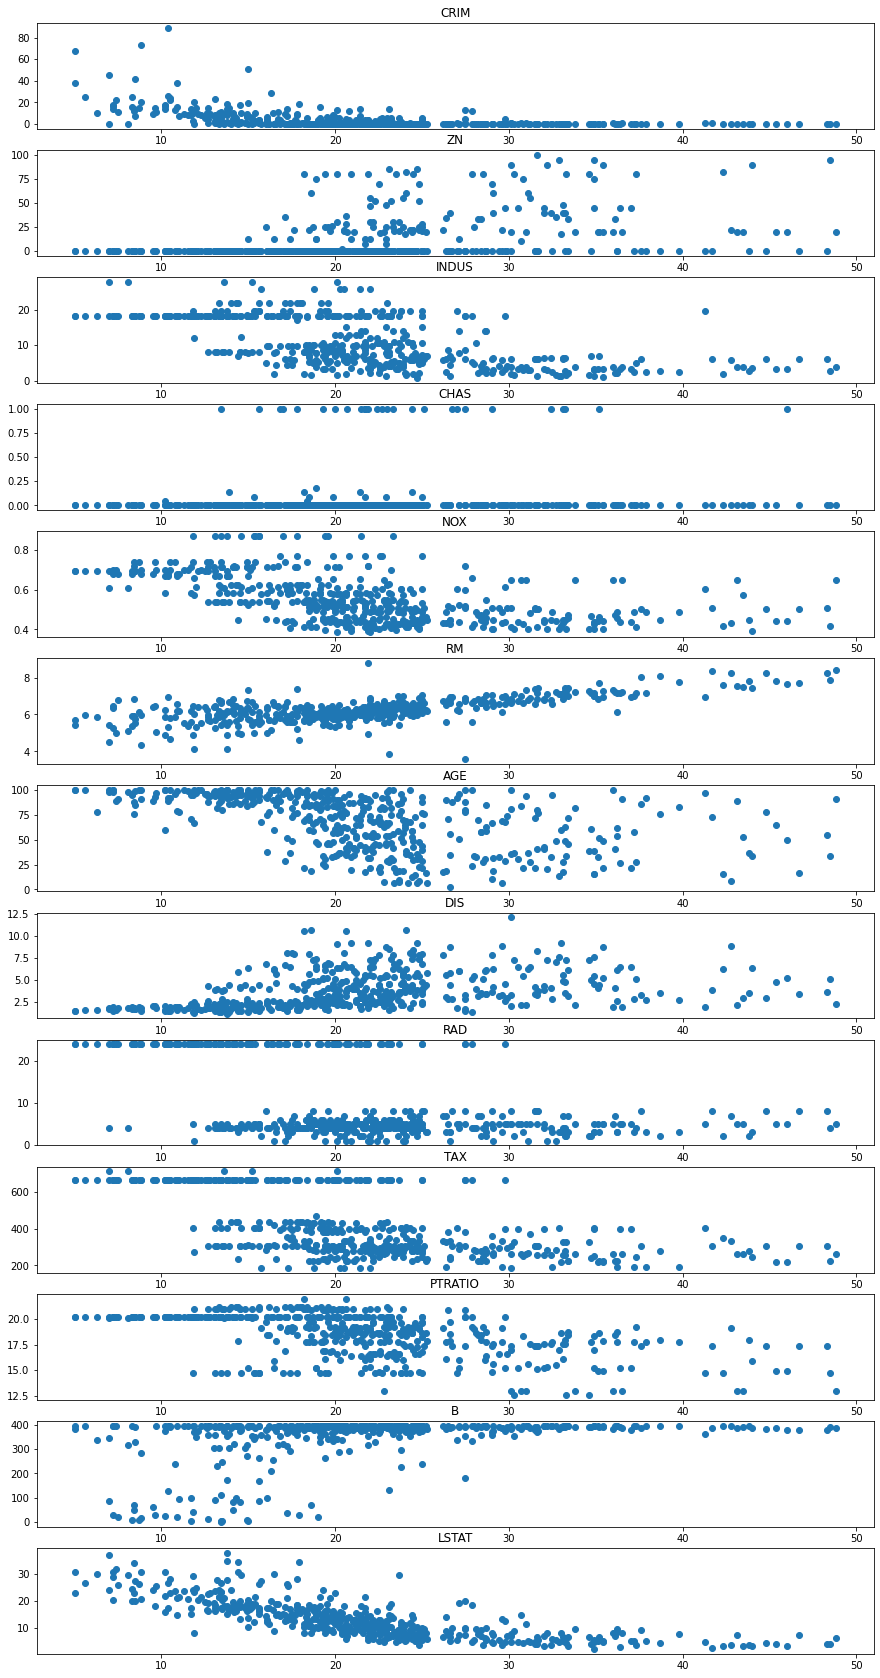

In [807]:
col_data=len(houses_data.columns)
plt.figure(figsize=[15,30])
for i in range(col_data):
  plt.subplot(col_data,1,i+1)
  plt.scatter(houses_value,houses_data.iloc[:,i])
  plt.title(houses_data.columns[i])

Vemos sin necesidad de analizar cada parametro estadisticamente que los datos estan dispersos en muchos de ellos. Esto dificulta a la hora de hacer una regresion y ya podemos predecir que las predicciones (valga la redundancia) no seran tan confiables. 

Divido los datos en conjuntos de testing y training. 

In [808]:
from sklearn.model_selection import train_test_split
[houses_train,houses_test,value_train,value_test]=train_test_split(houses_data,houses_value,train_size=0.5)


Con el pre-processing completado paso a la implementacion de los modelos. Antes sin embargo defino la variable "dataset_size" que sera de utilidad en varias partes del codigo.

In [809]:
dataset_size=len(houses.columns)

##Metodo de regresión 1 - Árbol de Regresión


Para este metodo hay algunos parametros de configuracion de interes:

- criterion: determina el criterio a utilizar, en nuestro caso sera mean square error (default).
- max_depth: la profundidad del arbol y uno de los parametros mas importantes para determinar la complejidad del modelo. 

El resto de los parametros pueden ser de interes (maxima cantidad de hojas, minima cantidad de hojas, minima cantidad de muestras para crear una division) pero para este trabajo lo dejare en sus valores por defecto.

Sobre la profundidad del arbol su valor optimo se identifica evaluando distintas iteraciones con distintos valores, ya que poca profundidad genera underfitting y mucha overfitting. Usare como metrica para esta evaluacion el coeficiente R^2. Tomo como parametro de profundidad optima la que corresponda al maximo valor *ANTES QUE* comience a bajar. Luego interrumpo la ejecucion del codigo.

In [810]:
from sklearn.tree import DecisionTreeRegressor    #importo el regresor
tree_regressor=DecisionTreeRegressor()  #aplico la profundidad de la iteracion

La profundidad optima es  4  con un coeficienre R^2 de  0.8198870043614289


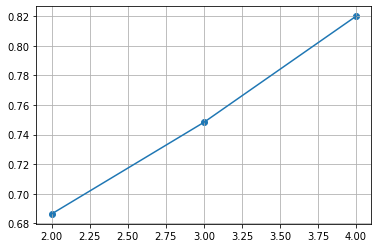

In [811]:
optimal_depth=2 #variable para guardar la profundidad optimo, menor valor posible por defecto
r_sqr_max=0     #variable para guardar el coeficiente R^2, menor valor posible por defecto
profundidad_inicial=2
profundidad_final=dataset_size
r_sqr=np.zeros(profundidad_final-profundidad_inicial)
rango=range(profundidad_inicial,profundidad_final)

for depth in rango:   #pruebo con valores de profudidad a partir de 2 y hasta la cantidad de columnas que tiene el dataset
  tree_regressor.set_params(max_depth=depth)
  tree_regressor.fit(houses_train,value_train)  #entreno el modelo
  r_sqr[depth-profundidad_inicial]=tree_regressor.score(houses_test,value_test)  #obtengo el coeficiente R^2
  if r_sqr[depth-profundidad_inicial]>r_sqr_max:     #si es el mejor coeficiente hasta ahora
    r_sqr_max=r_sqr[depth-profundidad_inicial]       #actualizo el mejor coeficiente
    optimal_depth=depth   #y guardo la profundiad que lo causo
  else:
    break

print('La profundidad optima es ',optimal_depth,' con un coeficienre R^2 de ', r_sqr_max)

plt.plot(range(profundidad_inicial,optimal_depth+1),r_sqr[0:optimal_depth-profundidad_inicial+1])
plt.scatter(range(profundidad_inicial,optimal_depth+1),r_sqr[0:optimal_depth-profundidad_inicial+1])
plt.grid(True)

Por la forma en la que el codigo trabaja (no tengo el insight suficiente) resulta que aunque dos modelos tengan la misma data y configuracion, el modelo entrenado no es el mismo. Esto hace que los valores optimos de profundidad varien al igual que el coeficiente R^2. Podria ir guardando los modelos a medida que los calculo, pero la diferencia es relativamente pequeña y suelen ser consistentes. Los valores estan entre 4, 5 y 6; siendo 5 el valor mas consistente de profundidad optima segun el criterio elegido. Aun asi se presentan algunos valores atipicos de vez en cuando.

Continuo el codigo con un modelo de profundidad igual a la optima de la iteracion. Ha de corroborarse que el indice R^2 sea similar al hallado en la evaluacion previa.

---



In [812]:
tree_regressor=DecisionTreeRegressor(max_depth=optimal_depth)  #aplico la profundidad de la iteracion
tree_regressor.fit(houses_train,value_train)  #entreno el modelo
r_sqr_final=tree_regressor.score(houses_test,value_test)  #obtengo el coeficiente R^2
print('La profundidad del arbol final es ',optimal_depth,', con un coeficienre R^2 de ', r_sqr_final)

La profundidad del arbol final es  4 , con un coeficienre R^2 de  0.8280478429384484


A continuacion obtengo la prediccion del arbol sobre el dataset de prueba, calculo el error respecto al valor real, grafico la distribucion del error (la cual idealmente decrecera a medida que el valor del error aumenta) y calculo el error medio cuadratico.

El error medio cuadratico de las predicciones es  13.182019943865217


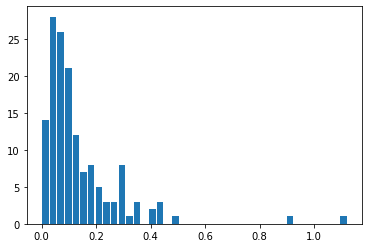

In [813]:
value_predicted=tree_regressor.predict(houses_test)    #obtengo las predicciones
error=(value_predicted-value_test)/value_test        #obtengo el error de cada medicion
error_abs=abs(error)         #paso los errores a valor absoluto
mse=mean_squared_error(value_test,value_predicted)
print('El error medio cuadratico de las predicciones es ',mse)

#preparo el histograma
intervalos=40 
plt.hist(error_abs,bins=intervalos,rwidth=0.85)
plt.show()

error_1=error

Vemos que el error medio cuadratico es bastante alto. Esto es por las predicciones atipicas que caen muy lejos de su valor real. 

##Metodo de regresión 2 - Regresión con Vector Soporte

Importo el metodo desde sklearn. Para el caso me interesan los parametros de configuracion del metodo:

- kernel: indica el kernel a utilizar para la regresion. Utilizare para el caso "poly", para generar una regresion polinomial.
- degree: el grado de la aproximacion polinomial.

Este ultimo parametro no tiene un valor optimo a priori o forma directa de encontrarlo. Realizo un estudio similar al caso anterior para la profundidad del arbol, esta vez evaluando distintos grados de polinomio.

In [814]:
from sklearn.svm import SVR
svr=SVR(kernel='poly')

Busco el grado optimo para el polinomio.

La grado optimo es  8  con un coeficienre R^2 de  0.3423486351535626


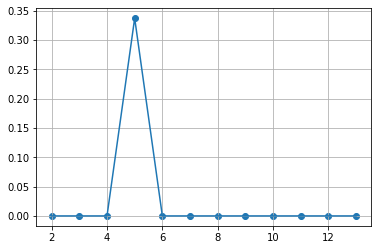

In [815]:
optimal_degree=2 #variable para guardar la profundidad optimo, menor valor posible por defecto
r_sqr_max=0     #variable para guardar el coeficiente R^2, menor valor posible por 
degree_inicial=2
degree_final=dataset_size
r_sqr=np.zeros(degree_final-degree_inicial)
rango=range(degree_inicial,degree_final)      #evaluo desde grado 2 (pues 1 seria lineal) 

for degree in rango:   #pruebo con valores de profudidad a partir de 2 y hasta la cantidad de columnas que tiene el dataset
  svr.set_params(degree=degree)
  svr.fit(houses_train,value_train)  #entreno el modelo
  r_sqr[depth-degree_inicial]=svr.score(houses_test,value_test)  #obtengo el coeficiente R^2
  if r_sqr[depth-degree_inicial]>r_sqr_max:     #si es el mejor coeficiente hasta ahora
    r_sqr_max=r_sqr[depth-degree_inicial]       #actualizo el mejor coeficiente
    optimal_degree=degree   #y guardo la profundiad que lo causo

print('La grado optimo es ',optimal_degree,' con un coeficienre R^2 de ', r_sqr_max)

plt.plot(rango,r_sqr)
plt.scatter(rango,r_sqr)
plt.grid(True)

Aplico al dataset.

In [816]:
svr.set_params(degree=optimal_degree)
svr.fit(houses_train,value_train)
r_sqr_final=svr.score(houses_test,value_test)  #obtengo el coeficiente R^2
print('El regresor por vector soporte tiene un coeficienre R^2 de ', r_sqr_final)

El regresor por vector soporte tiene un coeficienre R^2 de  0.3423486351535626


Vemos que el coeficiente R^2 es inferior al del arbol. Grafico los errores como en el caso anterior.

El error medio cuadratico de las predicciones es  50.41619457214901


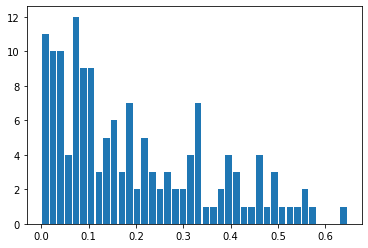

In [817]:
value_predicted=svr.predict(houses_test)    #obtengo las predicciones
error=(value_predicted-value_test)/value_test        #obtengo el error de cada medicion
error_abs=abs(error)         #paso los errores a valor absoluto
mse=mean_squared_error(value_test,value_predicted)
print('El error medio cuadratico de las predicciones es ',mse)

#preparo el histograma
intervalos=40 
plt.hist(error_abs,bins=intervalos,rwidth=0.85)
plt.show()


error_2=error

Vemos que el regresor vector soporte tiene una distribucion con mayor varianza respecto al arbol de regresion. Podemos tener un principio de conclusion con este resultado: SVR es inferior (para este ejercicio particular) que DTR, al menos manteniendo sus parametros por defecto.

##Metodo de regresión 3 - Regresión Lineal Múltiple

Para este ultimo caso los parametros destacables de la configuracion son:

- fit_intercept: si la regresion calculara el termino independiente. Por defecto esta activado lo cual es deseable.
- normalize: normaliza los datos para la regresion. En este caso no es de nuestro interes pero podria resultar util en otras situaciones.

A continuación importo e implemento el método. Se le hara el mismo análisis que a los anteriores.

In [818]:
from sklearn.linear_model import LinearRegression

lr=LinearRegression()

Aplico al dataset.

In [819]:
lr.fit(houses_train,value_train)
r_sqr_final=lr.score(houses_test,value_test)  #obtengo el coeficiente R^2
print('El regresor por vector soporte tiene un coeficienre R^2 de ', r_sqr_final)

El regresor por vector soporte tiene un coeficienre R^2 de  0.7775821292440914


Analizo los errores.

El error medio cuadratico de las predicciones es  17.05077073925231


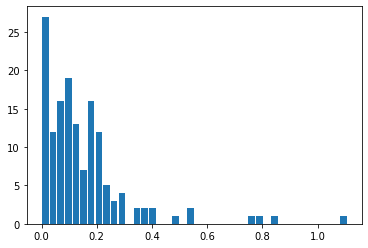

In [820]:
value_predicted=lr.predict(houses_test)    #obtengo las predicciones
error=(value_predicted-value_test)/value_test        #obtengo el error de cada medicion
error_abs=abs(error)         #paso los errores a valor absoluto
mse=mean_squared_error(value_test,value_predicted)
print('El error medio cuadratico de las predicciones es ',mse)

#preparo el histograma
intervalos=40 
plt.hist(error_abs,bins=intervalos,rwidth=0.85)
plt.show()

error_3=error

##Comparacion entre modelos.

La comparacion mas directa sera viendo las distribuciones de los errores, por los que vuelvo a graficarlas en comparativa a continuacion.

A diferencia de las instancias anteriores grafico el error con signo para que se aprecie la distribucion normal del mismo y los outliers.

(-3.0, 3.0)

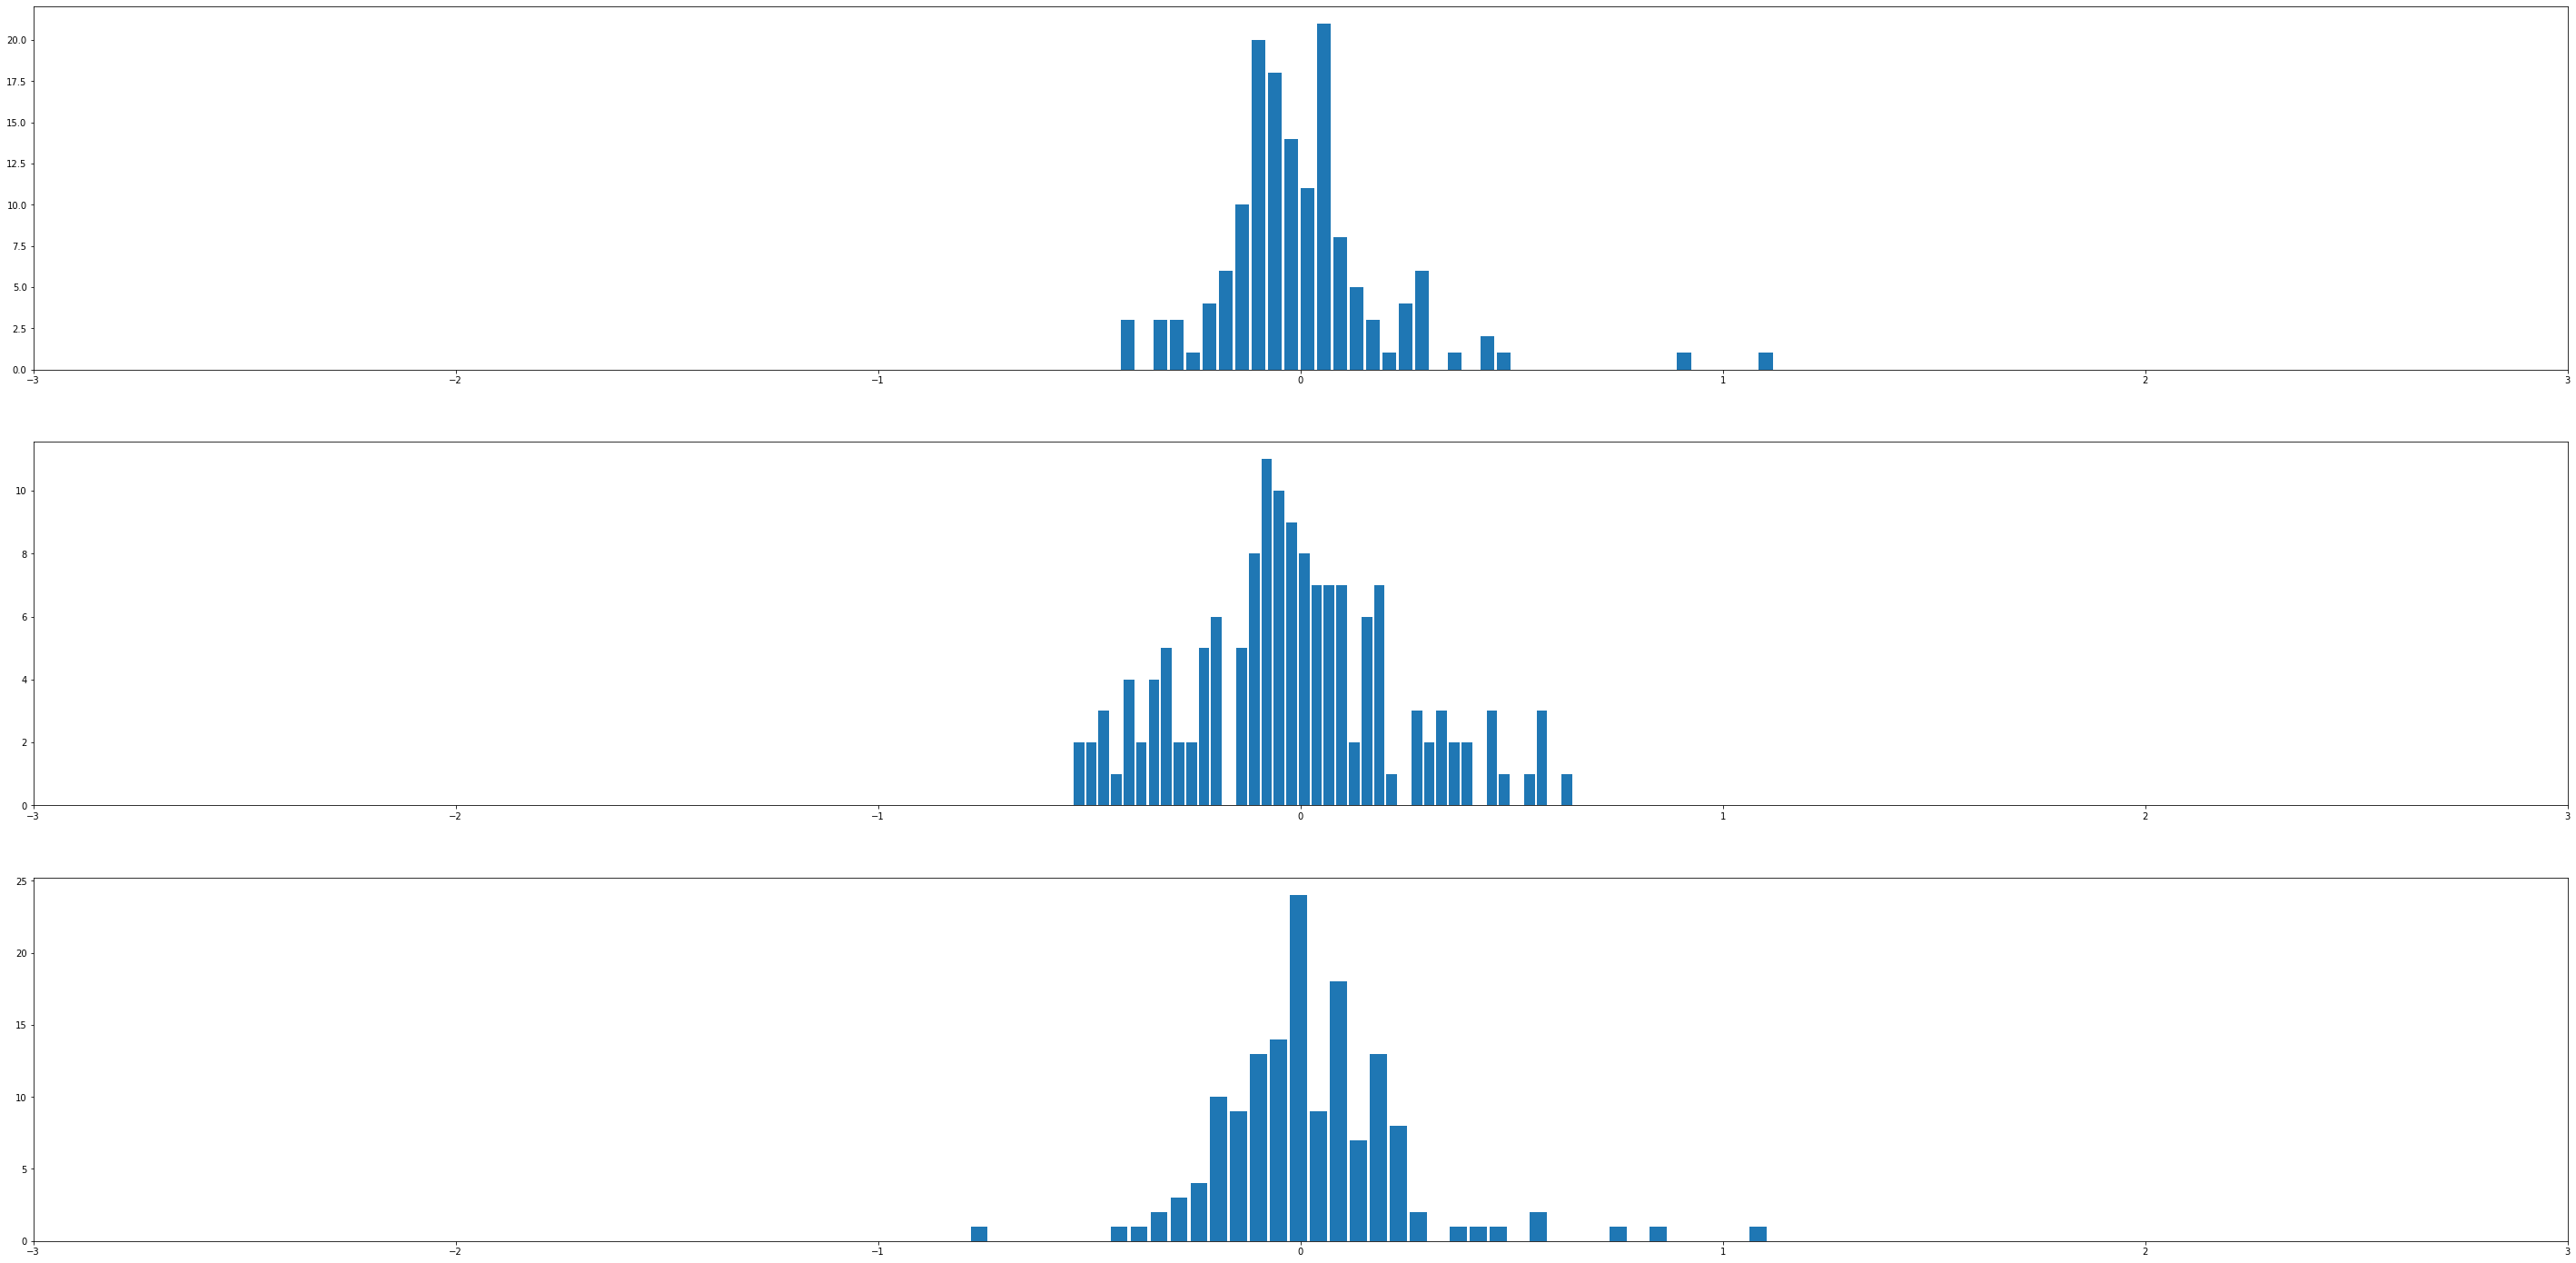

In [821]:
#preparo el histograma
plt.figure(figsize=(50,25))
plt.subplot(3,1,1)
intervalos=40 
plt.hist(error_1,bins=intervalos,rwidth=0.85)
plt.xlim(-3,3)
plt.subplot(3,1,2)
intervalos=40 
plt.hist(error_2,bins=intervalos,rwidth=0.85)
plt.xlim(-3,3)
plt.subplot(3,1,3)
intervalos=40 
plt.hist(error_3,bins=intervalos,rwidth=0.85)
plt.xlim(-3,3)

Podemos apreciar como las distribuciones de errores son muy similares en los tres casos. Por esta razon no podemos definir uno de ellos como el "ganador". Recordemos que el objetivo es predecir el precio de casas con el menor error posible.

##Variables de mayor influencia en el precio

Si bien los errores son considerables debemos recordar que el dataset no era "bonito". Aun asi los tres modelos resultan similares en la distribucion de las predicciones y por lo tanto *esperaria* que los parametros de mayor influencia sean los mismos en los tres casos.

Para analizar el regresor de árbol lo grafico.

[Text(466.78846153846155, 733.86, 'X[5] <= 6.825\nmse = 54.848\nsamples = 343\nvalue = 21.252'),
 Text(257.53846153846155, 570.78, 'X[12] <= 15.0\nmse = 27.556\nsamples = 292\nvalue = 19.208'),
 Text(128.76923076923077, 407.70000000000005, 'X[5] <= 6.544\nmse = 12.259\nsamples = 176\nvalue = 22.156'),
 Text(64.38461538461539, 244.62, 'X[12] <= 7.57\nmse = 8.025\nsamples = 147\nvalue = 21.264'),
 Text(32.19230769230769, 81.54000000000008, 'mse = 2.244\nsamples = 28\nvalue = 23.718'),
 Text(96.57692307692308, 81.54000000000008, 'mse = 7.635\nsamples = 119\nvalue = 20.687'),
 Text(193.15384615384616, 244.62, 'X[12] <= 5.39\nmse = 9.224\nsamples = 29\nvalue = 26.679'),
 Text(160.96153846153845, 81.54000000000008, 'mse = 1.691\nsamples = 7\nvalue = 29.643'),
 Text(225.34615384615387, 81.54000000000008, 'mse = 7.937\nsamples = 22\nvalue = 25.736'),
 Text(386.3076923076923, 407.70000000000005, 'X[12] <= 19.23\nmse = 17.566\nsamples = 116\nvalue = 14.734'),
 Text(321.9230769230769, 244.62, 'X[

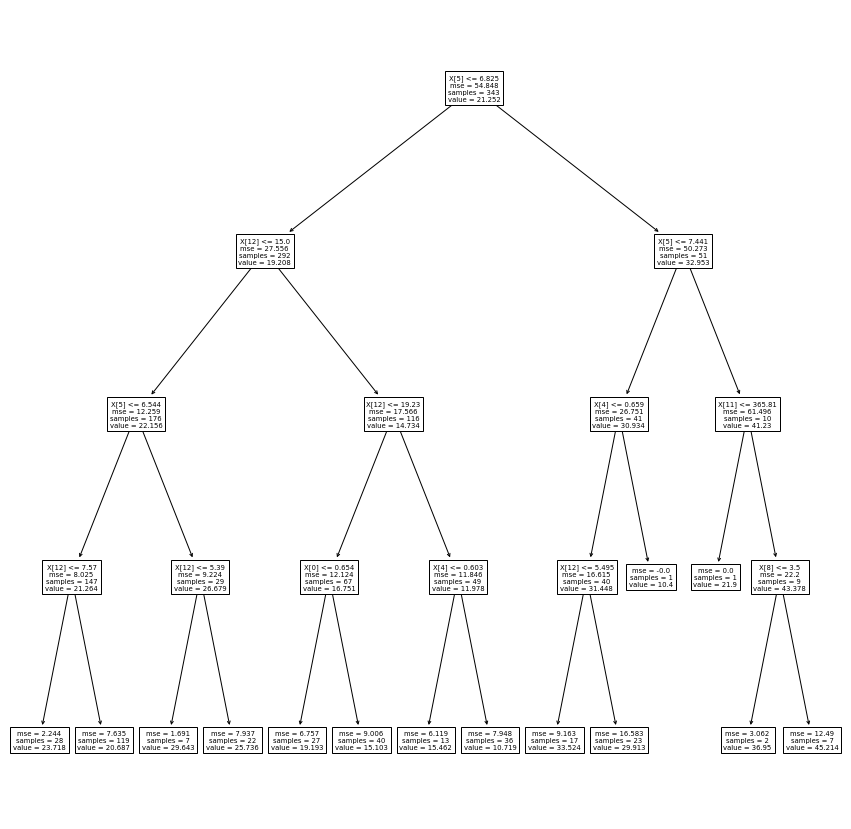

In [822]:
from sklearn.tree import plot_tree
plt.figure(figsize= [15,15])
plot_tree(tree_regressor)

Muestro las columnas que se utilizan para la decision, luego de haber iterado el procedimiento algunas veces para estar seguro que son consistentes. Las columnas son: 12, 5 y 4.

In [823]:
print('Los parametros de mayor influencia en el regresor de arbol son: ', houses_data.columns[12],', ',houses_data.columns[5],' y ',houses_data.columns[4])

Los parametros de mayor influencia en el regresor de arbol son:  LSTAT ,  RM  y  NOX


Analizar los parametros mas importantes en regresion por vector soporte no es trivial pues es una regresion polinomica. Podria hacerse de forma directa analizando los coeficientes para cada parametro si el kernel usado fuera lineal.

Para la regresion lineal simplemente recupero los coeficientes y veo cuales son los mas grandes en módulo. De esta forma vere los que mas afectan para bien o mal el precio. Para el caso tomare solo los 3 superiores para comparar con los 3 consistentes del árbol de regresión.

In [824]:
coeficientes=abs(lr.coef_)
coeficientes_aux=abs(lr.coef_)        
print(coeficientes)                    #obtengo los tres valores mas grandes, voy reduciendo los parametros en el camino
ub_aux_1=np.where(coeficientes_aux==max(coeficientes_aux))
max_1=coeficientes_aux[ub_aux_1]
coeficientes_aux=np.delete(coeficientes_aux,ub_aux_1)
print(max_1)
ub_aux_2=np.where(coeficientes_aux==max(coeficientes_aux))
max_2=coeficientes_aux[ub_aux_2]
coeficientes_aux=np.delete(coeficientes_aux,ub_aux_2)
print(max_2)
ub_aux_3=np.where(coeficientes_aux==max(coeficientes_aux))
max_3=coeficientes_aux[ub_aux_3]
print(max_3)

ub_1=np.where(coeficientes==max_1)              #obtengo las ubicaciones reales de esos coeficientes
ub_2=np.where(coeficientes==max_2)
ub_3=np.where(coeficientes==max_3)
print(ub_1,ub_2,ub_3)


[1.04893617e-01 3.54522708e-02 5.80122212e-02 1.13544963e+00
 1.24496092e+01 2.84028201e+00 9.80915150e-03 1.17560117e+00
 2.65725847e-01 1.34764053e-02 8.00611141e-01 7.50457109e-03
 4.20187017e-01]
[12.44960922]
[2.84028201]
[1.17560117]
(array([4]),) (array([5]),) (array([7]),)


In [825]:
print('Los parametros de mayor influencia en el regresor lineal son: ', houses_data.columns[ub_1],', ',houses_data.columns[ub_2],' y ',houses_data.columns[ub_3])

Los parametros de mayor influencia en el regresor lineal son:  Index(['NOX'], dtype='object') ,  Index(['RM'], dtype='object')  y  Index(['DIS'], dtype='object')


---

#MODELO EXTRA

Investigando me tope nuevamente con los random forests, los cuales usan bagging con arboles de decision. Implementar el bagging regressor con tree regressor no me dio mejoras significativas. A pesar de esto vi que este modelo random forest si suele mejorar por lo que le doy una chance rapida.

In [826]:
# Import Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest Regressor
reg = RandomForestRegressor(max_depth=optimal_depth)

# Train the model using the training sets 
reg.fit(houses_train, value_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

El error medio cuadratico de las predicciones es  10.374194090834726  y su coeficiente R^2 es  0.8646743777288527


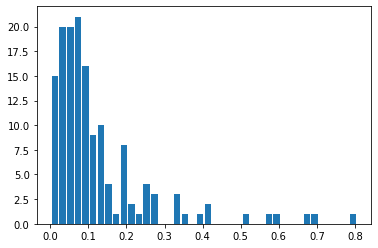

In [827]:
value_predicted=reg.predict(houses_test)    #obtengo las predicciones
error=(value_predicted-value_test)/value_test        #obtengo el error de cada medicion
error_abs=abs(error)         #paso los errores a valor absoluto
mse=mean_squared_error(value_test,value_predicted)
print('El error medio cuadratico de las predicciones es ',mse, ' y su coeficiente R^2 es ' , r2_score(value_test,value_predicted))

#preparo el histograma
intervalos=40 
plt.hist(error_abs,bins=intervalos,rwidth=0.85)
plt.show()

error_3=error

#***CONCLUSIONES***

Los modelos aproximan al dataset con un error que interpreto como considerable. Existen regularmente estimaciones muy alejadas (porcentualmente) del valor real. Aun asi la performance de los tres modelos es comparable. El modelo final de random forests no mostro una mejora que considere significativa.

En cuanto a las variables que mas afectan al precio de las casas se repiten dos con regularidad tanto en el regresor de arbol como en el lineal: 
- "RM": promedio de habitacaiones en casas de los alrededores, se ve plausible que a mayor numero de habitaciones alrededor, mayor es el propio y por lo tanto mayor el precio.
- "NOX": nivel de oxido de nitrogeno. No es necesario aclarar que me parece muy extraño que esto marque el precio tanto y deberia investigarse mas.

Un parametro regular en el arbol es:
-"LSTAT": El nivel de pobreza de la zona. Tiene sentido que esto afecte el precio de la casa considerablemente.

Un parametro menos regular en apariciones es:
-"CRIM": Nivel de crimen de la zona. Claramente deberia estar mas presente que NOX, por ejemplo.

Como cierre puedo decir que los modelos hicieron lo que pudieron con la data, incluso despues de ser esta pre-procesada. Los parametros que guian el precio de las casas tienen cierta logica en algunos casos, y en otros no tanto. Deberia contarse con un dataset mas grande u otras tecnicas de analisis para brindar resultados realmente concluyentes.